In [179]:
import easyocr
import cv2
from Levenshtein import distance, ratio
from fuzzywuzzy import fuzz
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import ast
from functools import cmp_to_key

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import regex as re
from datetime import timedelta

In [3]:
imgpath = './images/img.png'

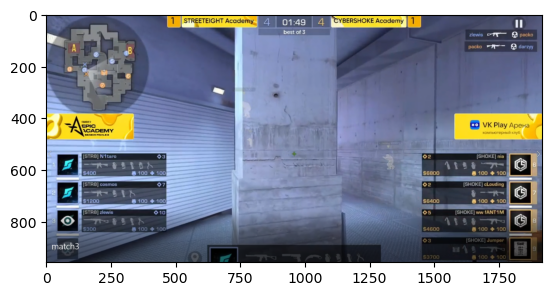

In [4]:
plt.imshow(plt.imread(imgpath))

In [8]:
def preprocess_video(input_video_path: str, output_video_path: str, crop_region: tuple):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise IOError('Cannot open video file')
    frame_with = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f'Original video {input_video_path}: {frame_with}x{frame_height}, {fps} FPS, {total_frames} total frames')
    x, y, w, h = (1500, 0, frame_with, frame_height)
    # x, y, w, h = crop_region
    fourcc = cv2.VideoWriter_fourcc(*'mpv4')  # Codec for mp4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        cropped_frame = frame[y:y + h, x:x + w]
        out.write(cropped_frame)

    cap.release()
    out.release()
    print(f'Processed Video saved to {output_video_path}')

In [9]:
input_video_path = './video/test_crop.mp4'
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise IOError('Cannot open video file')
frame_with = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'Original video {input_video_path}: {frame_with}x{frame_height}, {fps} FPS, {total_frames} total frames')

Original video ./video/test_crop.mp4: 1280x720, 30 FPS, 1547 total frames


In [17]:
process_frames = []
tenPercentFrames = total_frames / 10
for i in range(1, 10):
    process_frames.append((int(tenPercentFrames * i), i * 10))

In [18]:
process_frames

[(154, 10),
 (309, 20),
 (464, 30),
 (618, 40),
 (773, 50),
 (928, 60),
 (1082, 70),
 (1237, 80),
 (1392, 90)]

In [19]:
print(1500 / 1980 * 1280)

969.6969696969697


In [20]:
reader = easyocr.Reader(['en'], gpu=True)

In [21]:
type(reader)

easyocr.easyocr.Reader

In [117]:
all_kills_df = pd.read_csv('all_kills.csv')
all_kills_df = all_kills_df.drop(columns=['Unnamed: 0'], axis=1)
# all_kills_df.dropna(inplace=True)
all_kills_df['bbox'] = all_kills_df['bbox'].apply(ast.literal_eval)

In [86]:
nicknames = ['N1taro', 'cosmos', 'darzyy', 'zlewis', 'v1ZUAL', 'cLouding', 'ww fANT1M', 'nia', 'Jumper', 'packoo']

In [118]:
all_kills_df

,bbox,text,conf,time_s,current_frame
0,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.565397,0.933333,28
1,"[[263, 49], [285, 49], [285, 61], [263, 61]]",nia,0.296140,0.933333,28
2,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.592913,0.966667,29
3,"[[261, 49], [285, 49], [285, 61], [261, 61]]",nia,0.381045,0.966667,29
4,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NIteru,0.409679,1.000000,30
...,...,...,...,...,...
1864,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.720734,89.700000,2691
1865,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.733333,2692
1866,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.700355,89.733333,2692
1867,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.766667,2693


In [119]:
matched = False
for i, row in all_kills_df.iterrows():
    matched = False
    for nickname in nicknames:
        print(
            f'time {row["time_s"]} nickname: {nickname} | row text: {row["text"]} | ratio: {ratio(nickname, row["text"])}')
        if ratio(nickname, row['text']) > 0.7:
            all_kills_df.at[i, 'nickname'] = nickname
            matched = True
            break
    if not matched:
        all_kills_df.at[i, 'nickname'] = None
all_kills_df = all_kills_df.dropna(subset=['nickname'])

time 0.9333333333333332 nickname: N1taro | row text: NItaro | ratio: 0.8333333333333334
time 0.9333333333333332 nickname: N1taro | row text: nia | ratio: 0.2222222222222222
time 0.9333333333333332 nickname: cosmos | row text: nia | ratio: 0.0
time 0.9333333333333332 nickname: darzyy | row text: nia | ratio: 0.2222222222222222
time 0.9333333333333332 nickname: zlewis | row text: nia | ratio: 0.2222222222222222
time 0.9333333333333332 nickname: v1ZUAL | row text: nia | ratio: 0.0
time 0.9333333333333332 nickname: cLouding | row text: nia | ratio: 0.18181818181818182
time 0.9333333333333332 nickname: ww fANT1M | row text: nia | ratio: 0.0
time 0.9333333333333332 nickname: nia | row text: nia | ratio: 1.0
time 0.9666666666666668 nickname: N1taro | row text: NItaro | ratio: 0.8333333333333334
time 0.9666666666666668 nickname: N1taro | row text: nia | ratio: 0.2222222222222222
time 0.9666666666666668 nickname: cosmos | row text: nia | ratio: 0.0
time 0.9666666666666668 nickname: darzyy | row

In [132]:
top = 206
centers_x = []
centers_y = []
for i, row in all_kills_df.iterrows():
    (top_left, top_right, bottom_right, bottom_left) = row['bbox']
    centers_x.append((top_left[0] + top_right[0]) / 2)
    centers_y.append((top - top_left[1] + top - bottom_left[1]) / 2)
all_kills_df['center_x'] = centers_x
all_kills_df['center_y'] = centers_y

C:\Users\mrbab\AppData\Local\Temp\ipykernel_3936\1978860237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_kills_df['center_x'] = centers_x
C:\Users\mrbab\AppData\Local\Temp\ipykernel_3936\1978860237.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_kills_df['center_y'] = centers_y


In [133]:
all_kills_df

,bbox,text,conf,time_s,current_frame,nickname,center_x,center_y
0,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.565397,0.933333,28,N1taro,148.0,152.0
1,"[[263, 49], [285, 49], [285, 61], [263, 61]]",nia,0.296140,0.933333,28,nia,274.0,151.0
2,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.592913,0.966667,29,N1taro,148.0,152.0
3,"[[261, 49], [285, 49], [285, 61], [261, 61]]",nia,0.381045,0.966667,29,nia,273.0,151.0
5,"[[261, 47], [285, 47], [285, 61], [261, 61]]",nia,0.917480,1.000000,30,nia,273.0,152.0
...,...,...,...,...,...,...,...,...
1864,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.720734,89.700000,2691,cLouding,265.0,151.0
1865,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.733333,2692,zlewis,104.0,152.0
1866,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.700355,89.733333,2692,cLouding,265.0,151.0
1867,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.766667,2693,zlewis,104.0,152.0


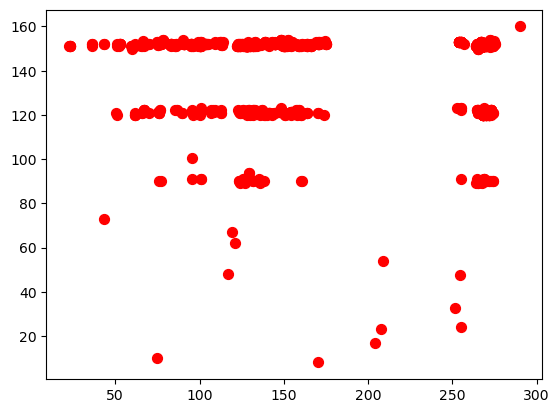

In [134]:
plt.scatter(all_kills_df.center_x, all_kills_df.center_y, s=50, c='r')

In [137]:
all_kills_df = all_kills_df.query('center_y > 80')

In [178]:
current_frame_idx = all_kills_df['current_frame'].unique()

In [177]:
def center_comparator(lhs_row, rhs_row):
    lhs_center_x = lhs_row['center_x']
    rhs_center_x = rhs_row['center_x']
    lhs_center_y = lhs_row['center_y']
    rhs_center_y = rhs_row['center_y']

    if abs(lhs_center_y - rhs_center_y) < 5:
        return lhs_center_x - rhs_center_x
    else:
        return rhs_center_y - lhs_center_y

In [200]:
formatted_time = pd.read_csv('formatted_time.csv')

In [201]:
formatted_time

,left_score,center_score,right_score,time_s,frame,pretty_time,left_pretty_score,right_pretty_score
0,0,00;12,NaN,0.033333,1,00:12,0,0
1,0,00;12,NaN,0.066667,2,00:12,0,0
2,0,00;12,NaN,0.100000,3,00:12,0,0
3,NaN,00;1n1,NaN,0.133333,4,00:11,0,0
4,NaN,00:10,NaN,0.166667,5,00:10,0,0
...,...,...,...,...,...,...,...,...
2396,10,0O UR,12.0,89.500000,2685,00:07,10,12
2397,10,"00,06",12.0,89.533333,2686,00:06,10,12
2398,10,"00,05",12.0,89.566667,2687,00:05,10,12
2399,10,00 04,12.0,89.600000,2688,00:04,10,12


In [294]:
match_df = pd.DataFrame(
    columns=['frame', 'time_s', 'active_player', 'helper_player', 'passive_player', 'left_score', 'time_score',
             'right_score'])
for i in current_frame_idx:
    # fetch all players by current frame
    current_player_score_df = all_kills_df.query(f'current_frame == {i}')
    current_time_df = formatted_time.query(f'frame == {i}')
    if current_time_df.empty:
        current_time_df = {
            'time_s': None,
            'left_pretty_score': None,
            'pretty_time': None,
            'right_pretty_score': None,
        }
    else:
        current_time_df = current_time_df.iloc[0]
    # sort them by center_y and center_x
    sorted_player_score = pd.DataFrame(
        sorted((current_player_score_df.to_dict('records')), key=cmp_to_key(center_comparator)))
    # flatten center_y values
    for j in range(0, len(sorted_player_score) - 1):
        if sorted_player_score.iloc[j]['center_y'] - sorted_player_score.iloc[j + 1]['center_y'] < 5:
            sorted_player_score.at[j, 'center_y'] = sorted_player_score.iloc[j + 1]['center_y']
    # fetch all center_y values and group record by it
    center_y_idxs = sorted_player_score['center_y'].unique()
    
    for center_y_idx in center_y_idxs:
        # fetch 2 or 3 players in one row
        score_row = sorted_player_score.query(f'center_y == {center_y_idx}')
        players_count = len(score_row)
        if players_count < 2 or players_count > 3:
            continue
        # choose who is active_player/helper_player/passive_player by their place
        active_player, helper_player, passive_player = None, None, None
        if players_count == 2:
            active_player = score_row.iloc[0]['nickname']
            passive_player = score_row.iloc[1]['nickname']
        if players_count == 3:
            active_player = score_row.iloc[0]['nickname']
            helper_player = score_row.iloc[1]['nickname']
            passive_player = score_row.iloc[2]['nickname']

        new_row = pd.DataFrame({
            'frame': [i],
            'time_s': [sorted_player_score.iloc[0]['time_s']],
            'active_player': [active_player],
            'helper_player': [helper_player],
            'passive_player': [passive_player],
            'left_score': [current_time_df['left_pretty_score']],
            'time_score': [current_time_df['pretty_time']],
            'right_score': [current_time_df['right_pretty_score']]
        })
        match_df = pd.concat([match_df, pd.DataFrame(new_row)])

In [295]:
match_df = match_df.sort_values(by=['frame'])
match_df.to_csv('match.csv')

In [296]:
match_df

,frame,time_s,active_player,helper_player,passive_player,left_score,time_score,right_score
0,28,0.933333,N1taro,None,nia,0,01:52,0
0,29,0.966667,N1taro,None,nia,0,01:51,0
0,31,1.033333,packoo,None,cosmos,0,01:49,0
0,32,1.066667,packoo,None,cosmos,0,01:48,0
0,33,1.100000,packoo,None,cosmos,0,01:47,0
...,...,...,...,...,...,...,...,...
0,2689,89.633333,zlewis,None,cLouding,10,00:03,13
0,2690,89.666667,zlewis,None,cLouding,None,None,None
0,2691,89.700000,zlewis,None,cLouding,None,None,None
0,2692,89.733333,zlewis,None,cLouding,None,None,None


In [298]:
match_time_score = list(match_df.time_score)
match_timedelta = []
current_time = timedelta(minutes=2, seconds=3)
full_time_score = [match_df.iloc[0]['time_score'] or current_time]

for i in range(1, len(match_df)):
    time_score = match_df.iloc[i]['time_score']
    if time_score == None:
        current_time -= timedelta(seconds=match_df.iloc[i]['frame'] - match_df.iloc[i - 1]['frame'])
    else:
        result = re.split('[:,.;]', str(time_score))
        current_time = timedelta(minutes=int(result[0]), seconds=int(result[1]))
    hh, mm, ss = str(current_time).split(':')
    full_time_score.append(f'{mm}:{ss}')
    
match_df['time_score'] = full_time_score

In [317]:
full_left_score = [match_df.iloc[0]['left_score'] or 0]
full_right_score = [match_df.iloc[0]['left_score'] or 0]
for i in range(1, len(match_df)):
    if match_df.iloc[i]['left_score'] is None:
        full_left_score.append(full_left_score[i - 1])
    else:
        full_left_score.append(match_df.iloc[i]['left_score'])
    if match_df.iloc[i]['right_score'] is None:
        full_right_score.append(full_right_score[i - 1])
    else:
        full_right_score.append(match_df.iloc[i]['right_score'])
match_df['right_score'] = full_right_score
match_df['left_score'] = full_left_score

In [325]:
match_df = match_df.drop_duplicates(subset=['active_player', 'helper_player', 'passive_player', 'left_score', 'right_score'])

In [336]:
assistance_df = match_df[match_df['helper_player'].notna()]

In [352]:
print(match_df.head())

  frame    time_s active_player helper_player passive_player  left_score  \
0    28  0.933333        N1taro          None            nia           0   
0    31  1.033333        packoo          None         cosmos           0   
0    55  1.833333        zlewis          None         Jumper           0   
0    70  2.333333        packoo          None         v1ZUAL           0   
0    93  3.100000        darzyy          None       cLouding           0   

  time_score  right_score  
0      01:52            0  
0      01:49            0  
0      01:25            0  
0      01:10            0  
0      00:47            0  


In [364]:
exceed_rows = []
for i, assistance_row in assistance_df.iterrows():
    found = match_df.query(f'active_player == "{assistance_row["active_player"]}" and passive_player == "{assistance_row["passive_player"]}" and left_score == {assistance_row["left_score"]} and right_score == {assistance_row["right_score"]} and helper_player != "{assistance_row["helper_player"]}"')
    if not found.empty:
        exceed_rows.append(found.iloc[0]['frame'])
match_df = match_df[~match_df['frame'].isin(exceed_rows)]

In [365]:
match_df

,frame,time_s,active_player,helper_player,passive_player,left_score,time_score,right_score
0,28,0.933333,N1taro,None,nia,0,01:52,0
0,31,1.033333,packoo,None,cosmos,0,01:49,0
0,55,1.833333,zlewis,None,Jumper,0,01:25,0
0,70,2.333333,packoo,None,v1ZUAL,0,01:10,0
0,95,3.166667,darzyy,zlewis,cLouding,0,00:45,0
...,...,...,...,...,...,...,...,...
0,2621,87.366667,nia,None,cosmos,10,01:11,12
0,2624,87.466667,nia,None,N1taro,10,01:08,12
0,2677,89.233333,packoo,None,darzyy,10,00:15,12
0,2682,89.400000,cLouding,None,v1ZUAL,10,00:10,12


In [366]:
match_df.to_csv('match.csv')

In [361]:
exceed_rows

[93, 1332, 2136, 2404]

In [337]:
assistance_df

,frame,time_s,active_player,helper_player,passive_player,left_score,time_score,right_score
0,95,3.166667,darzyy,zlewis,cLouding,0,00:45,0
0,428,14.266667,packoo,Jumper,darzyy,1,59:48,0
0,601,20.033333,ww fANT1M,Jumper,N1taro,3,01:40,0
0,1210,40.333333,cLouding,Jumper,cosmos,6,01:06,3
0,1330,44.333333,nia,ww fANT1M,N1taro,6,00:37,4
0,2137,71.233333,Jumper,ww fANT1M,zlewis,7,01:04,11
0,2406,80.200000,cLouding,Jumper,darzyy,9,00:46,11


In [326]:
match_df.to_csv('match.csv')

In [ ]:
sorted_test = pd.DataFrame(sorted((test_df.to_dict('records')), key=cmp_to_key(center_comparator)))

In [162]:
test_df = all_kills_df.query('current_frame == 601')

In [159]:
from functools import cmp_to_key

In [173]:
sorted_test = pd.DataFrame(sorted((test_df.to_dict('records')), key=cmp_to_key(center_comparator)))

{'bbox': [[129, 47], [179, 47], [179, 61], [129, 61]], 'text': 'Jumper', 'conf': 0.9965907381869392, 'time_s': 20.03333333333333, 'current_frame': 601, 'nickname': 'Jumper', 'center_x': 154.0, 'center_y': 152.0}
154.0
{'bbox': [[245, 47], [293, 47], [293, 61], [245, 61]], 'text': 'Nitaro', 'conf': 0.749743610639459, 'time_s': 20.03333333333333, 'current_frame': 601, 'nickname': 'N1taro', 'center_x': 269.0, 'center_y': 152.0}
269.0
{'bbox': [[153, 79], [175, 79], [175, 91], [153, 91]], 'text': 'nia', 'conf': 0.9950178726490364, 'time_s': 20.03333333333333, 'current_frame': 601, 'nickname': 'nia', 'center_x': 164.0, 'center_y': 121.0}
164.0
{'bbox': [[250, 76], [295, 76], [295, 95], [250, 95]], 'text': 'derzyy', 'conf': 0.5697143046624091, 'time_s': 20.03333333333333, 'current_frame': 601, 'nickname': 'darzyy', 'center_x': 272.5, 'center_y': 120.5}
272.5
{'bbox': [[105, 107], [153, 107], [153, 123], [105, 123]], 'text': 'Nitaro', 'conf': 0.6117914656601696, 'time_s': 20.03333333333333, '

In [171]:
test_df

,bbox,text,conf,time_s,current_frame,nickname,center_x,center_y
383,"[[39, 45], [119, 45], [119, 61], [39, 61]]",Wnw fANTIM,0.167023,20.033333,601,ww fANT1M,79.0,153.0
384,"[[129, 47], [179, 47], [179, 61], [129, 61]]",Jumper,0.996591,20.033333,601,Jumper,154.0,152.0
386,"[[245, 47], [293, 47], [293, 61], [245, 61]]",Nitaro,0.749744,20.033333,601,N1taro,269.0,152.0
387,"[[153, 79], [175, 79], [175, 91], [153, 91]]",nia,0.995018,20.033333,601,nia,164.0,121.0
388,"[[250, 76], [295, 76], [295, 95], [250, 95]]",derzyy,0.569714,20.033333,601,darzyy,272.5,120.5
389,"[[105, 107], [153, 107], [153, 123], [105, 123]]",Nitaro,0.611791,20.033333,601,N1taro,129.0,91.0
390,"[[243, 109], [295, 109], [295, 123], [243, 123]]",Jumper,0.908677,20.033333,601,Jumper,269.0,90.0


In [174]:
sorted_test

,bbox,text,conf,time_s,current_frame,nickname,center_x,center_y
0,"[[39, 45], [119, 45], [119, 61], [39, 61]]",Wnw fANTIM,0.167023,20.033333,601,ww fANT1M,79.0,153.0
1,"[[129, 47], [179, 47], [179, 61], [129, 61]]",Jumper,0.996591,20.033333,601,Jumper,154.0,152.0
2,"[[245, 47], [293, 47], [293, 61], [245, 61]]",Nitaro,0.749744,20.033333,601,N1taro,269.0,152.0
3,"[[153, 79], [175, 79], [175, 91], [153, 91]]",nia,0.995018,20.033333,601,nia,164.0,121.0
4,"[[250, 76], [295, 76], [295, 95], [250, 95]]",derzyy,0.569714,20.033333,601,darzyy,272.5,120.5
5,"[[105, 107], [153, 107], [153, 123], [105, 123]]",Nitaro,0.611791,20.033333,601,N1taro,129.0,91.0
6,"[[243, 109], [295, 109], [295, 123], [243, 123]]",Jumper,0.908677,20.033333,601,Jumper,269.0,90.0


In [156]:
for i in current_frane_idx:


28
29
30
31
32
33
34
55
56
57
58
69
70
71
72
73
93
94
95
96
97
98
99
100
101
102
104
105
175
176
177
178
182
183
184
195
196
197
198
199
217
218
219
220
221
265
266
267
268
269
327
328
329
330
331
380
381
382
383
392
393
394
395
396
397
406
407
408
409
412
413
414
415
420
421
422
423
425
426
427
428
429
430
431
480
481
482
483
484
485
502
503
504
505
506
518
543
544
545
546
547
548
549
550
591
592
593
594
595
598
599
600
601
602
603
604
647
648
649
650
651
652
709
710
711
712
719
720
721
734
735
736
737
751
752
753
754
755
756
757
758
762
763
764
806
807
808
809
810
812
813
814
815
816
841
842
843
844
845
846
847
868
869
870
871
872
877
878
879
880
881
882
883
884
885
890
891
892
893
894
895
938
939
940
941
942
952
953
954
955
956
961
962
963
964
965
978
979
980
1000
1001
1002
1003
1004
1027
1028
1029
1031
1032
1033
1034
1072
1073
1074
1075
1076
1077
1087
1088
1089
1090
1091
1092
1093
1114
1115
1116
1117
1118
1119
1120
1121
1125
1126
1127
1128
1129
1182
1184
1198
1199
1200
1201
1202
12

In [148]:
all_kills_df.query('current_frame == 601')

,bbox,text,conf,time_s,current_frame,nickname,center_x,center_y
383,"[[39, 45], [119, 45], [119, 61], [39, 61]]",Wnw fANTIM,0.167023,20.033333,601,ww fANT1M,79.0,153.0
384,"[[129, 47], [179, 47], [179, 61], [129, 61]]",Jumper,0.996591,20.033333,601,Jumper,154.0,152.0
386,"[[245, 47], [293, 47], [293, 61], [245, 61]]",Nitaro,0.749744,20.033333,601,N1taro,269.0,152.0
387,"[[153, 79], [175, 79], [175, 91], [153, 91]]",nia,0.995018,20.033333,601,nia,164.0,121.0
388,"[[250, 76], [295, 76], [295, 95], [250, 95]]",derzyy,0.569714,20.033333,601,darzyy,272.5,120.5
389,"[[105, 107], [153, 107], [153, 123], [105, 123]]",Nitaro,0.611791,20.033333,601,N1taro,129.0,91.0
390,"[[243, 109], [295, 109], [295, 123], [243, 123]]",Jumper,0.908677,20.033333,601,Jumper,269.0,90.0


In [147]:
all_kills_df[['current_frame', 'nickname']].groupby('current_frame').count().query('nickname > 4')

,nickname
current_frame,
96,7
97,5
601,7
602,7
603,5
1209,5
1519,7
1520,5
1663,5


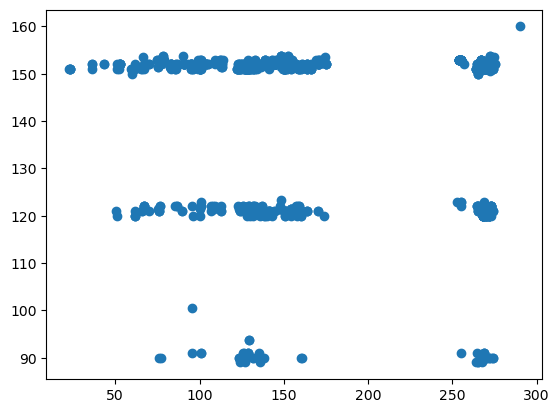

In [138]:
plt.scatter(all_kills_df.center_x, all_kills_df.center_y)

In [114]:
mess.to_csv('mess.csv', index=False)

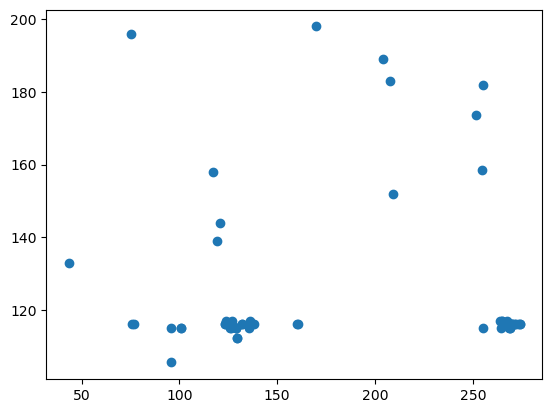

In [109]:
plt.scatter(mess.center_x, mess.center_y)

In [103]:
all_kills_df.query('center_y > 130')

,Unnamed: 0,bbox,text,conf,time_s,current_frame,nickname,center_x,center_y
166,166,"[[181, 145], [237, 145], [237, 159], [181, 159]]",Cosmos,0.554359,9.666667,290,cosmos,209.0,152.0
534,534,"[[83, 131], [155, 131], [155, 147], [83, 147]]",cosmos 1,0.947601,25.600000,768,cosmos,119.0,139.0
536,536,"[[91, 137], [151, 137], [151, 151], [91, 151]]",cosinos,0.748278,25.633333,769,cosmos,121.0,144.0
627,627,"[[178, 174], [237, 174], [237, 192], [178, 192]]",Jumnner,0.287407,30.300000,909,Jumper,207.5,183.0
680,680,"[[63, 189], [87, 189], [87, 203], [63, 203]]",nia,0.885328,33.366667,1001,nia,75.0,196.0
792,792,"[[151, 179], [257, 179], [257, 199], [151, 199]]",packoo 100Y,0.410252,37.800000,1134,packoo,204.0,189.0
795,795,"[[14, 124], [73, 124], [73, 142], [14, 142]]",Jumpei,0.373841,38.100000,1143,Jumper,43.5,133.0
800,800,"[[141, 191], [199, 191], [199, 205], [141, 205]]",Jumpei,0.199619,38.200000,1146,Jumper,170.0,198.0
963,963,"[[87, 151], [147, 151], [147, 165], [87, 165]]",Jumiplr,0.385775,46.233333,1387,Jumper,117.0,158.0
1701,1701,"[[198, 170], [312, 170], [312, 194], [198, 194]]",Jumper 100%,0.719696,81.000000,2430,Jumper,255.0,182.0


# Будем брать значения, у которых y = 55 или 85 c std = 2

In [153]:
filtered_df = all_kills_df[all_kills_df['nickname'].notna()]
filtered_df = filtered_df.query('center_y > 53 & center_y < 57 | center_y > 83 & center_y < 87 & center_x > ')

In [168]:
filtered_df

,Unnamed: 0,bbox,text,conf,time_s,nickname,center_x,center_y
0,0,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.565397,0.933333,N1taro,148.0,54.0
1,1,"[[263, 49], [285, 49], [285, 61], [263, 61]]",nia,0.296140,0.933333,nia,274.0,55.0
2,2,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.592913,0.966667,N1taro,148.0,54.0
3,3,"[[261, 49], [285, 49], [285, 61], [261, 61]]",nia,0.381045,0.966667,nia,273.0,55.0
5,5,"[[261, 47], [285, 47], [285, 61], [261, 61]]",nia,0.917480,1.000000,nia,273.0,54.0
...,...,...,...,...,...,...,...,...
1864,1864,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.720734,89.700000,cLouding,265.0,55.0
1865,1865,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.733333,zlewis,104.0,54.0
1866,1866,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.700355,89.733333,cLouding,265.0,55.0
1867,1867,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.766667,zlewis,104.0,54.0


In [51]:
cleared_words = []
for i, word in enumerate(words):
    should_remove = True
for nickname in nicknames:
    # print(f'nickname: {nickname}, word {word}, ration {ratio(nickname, word)}')
    if ratio(nickname, word) > 0.7:
        should_remove = False
if not should_remove:
    cleared_words.append(word)

In [52]:
# Calculate similarity matrix
n = len(cleared_words)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        similarity_matrix[i][j] = ratio(cleared_words[i], cleared_words[j])  # Use Levenshtein ratio

In [ ]:
# Convert similarity to distance (1 - similarity)
distance_matrix = 1 - similarity_matrix

# Apply clustering
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete',
                                     distance_threshold=0.3)
labels = clustering.fit_predict(distance_matrix)

In [54]:
clustering.n_clusters_

45

In [55]:
# Group words by clusters
clusters = {}
for word, label in zip(cleared_words, labels):
    clusters.setdefault(label, []).append(word)

In [56]:
# Print results
for cluster_id, cluster_words in clusters.items():
    print(f"Cluster {cluster_id}: {cluster_words}")

Cluster 5: ['NItaro', 'Nitaro', 'Nitar', 'Ntaro', 'Ntearo', 'Ntlaro', 'Nttaro']
Cluster 28: ['nia', 'nia ']
Cluster 23: ['packoo', 'packod', 'packou', 'packon', 'packop', 'packoa', 'packdo', 'packob']
Cluster 4: ['cosmos', 'cosmos 1', 'cusmos']
Cluster 21: ['zlewis', 'zlewwis', 'ziewis', 'zlewis:', 'zlewvis']
Cluster 0: ['Jumper', 'Jumpor', 'Jumiplr', 'Jumiper', 'JJumper', 'Jumpur', 'Jumpar']
Cluster 14: ['MZUAL', '1ZUAL', 'TZUAL', 'JZUAL', 'IZUAL']
Cluster 32: ['~paokoo', 'paokoo']
Cluster 9: ['darzw', 'darzvy', 'darzwy', 'darzyv', 'darzv', 'darzn']
Cluster 17: ['cLuuding', 'cLaudinu', 'cLaudina', 'cLuudinu', 'cLauding']
Cluster 19: ['darzyy', 'darzty', 'darzy', 'darzyy-']
Cluster 10: ['Ilewis', 'dewis', 'Zlewis']
Cluster 36: ['cLouding', 'cLoudlng', 'cLouding ', 'cLooding']
Cluster 42: ['zlewvib', 'zlewib', 'zewib']
Cluster 11: ['Ww fANTIM', 'Wnw fANTIM', 'Ww fANT', 'Ww fANTTM', 'W fANTIM']
Cluster 13: ['dariy', 'darzi']
Cluster 2: ['uckoo', 'puckoo', 'prckoo', 'pockoo']
Cluster 15: 

In [97]:
clusters.get(1)

['zlewia', 'zlewvig', 'zlewig', 'zlewvid', 'zlewie', 'zle wig', 'zlewjig']

In [78]:
def cluster_similarity(cluster1: list, cluster2: list) -> float:
    similarities = []
    for word1 in cluster1:
        for word2 in cluster2:
            similarities.append(ratio(word1, word2))
    # Return the average similarity
    return float(np.mean(similarities))

In [79]:
v = cluster_similarity(clusters.get(11), clusters.get(17))
print(float(v))

0.022222222222222223


In [67]:
type(clusters)

dict

In [81]:
clusters_similarity_matrix = np.zeros((n, n))
clusters_similarity_threshold = 0.6
for i in clusters:
    for j in clusters:
        same_clusters = False
        similarity_value = cluster_similarity(clusters.get(i), clusters.get(j))
        clusters_similarity_matrix[i][j] = similarity_value > clusters_similarity_threshold

In [90]:
def dfs(node, similarity_matrix_parameter, visited, component, n):
    visited[node] = True
    component.append(node)
    for i in range(n):
        if similarity_matrix_parameter[node][i] and not visited[i]:
            dfs(i, similarity_matrix_parameter, visited, component, n)


def find_clusters(similarity_matrix_parameter):
    n = len(similarity_matrix_parameter)  # Number of elements (words)
    visited = [False] * n  # Track visited nodes
    clusters_parameter = []  # List to store the clusters

    for i in range(n):
        if not visited[i]:
            component = []  # Start a new component (cluster)
            dfs(i, similarity_matrix_parameter, visited, component, n)
            clusters_parameter.append(component)  # Add the component to the clusters list

    return clusters_parameter

In [91]:
cls = find_clusters(clusters_similarity_matrix)

{5: ['NItaro', 'Nitaro', 'Nitar', 'Ntaro', 'Ntearo', 'Ntlaro', 'Nttaro'],
 28: ['nia', 'nia '],
 23: ['packoo',
  'packod',
  'packou',
  'packon',
  'packop',
  'packoa',
  'packdo',
  'packob'],
 4: ['cosmos', 'cosmos 1', 'cusmos'],
 21: ['zlewis', 'zlewwis', 'ziewis', 'zlewis:', 'zlewvis'],
 0: ['Jumper', 'Jumpor', 'Jumiplr', 'Jumiper', 'JJumper', 'Jumpur', 'Jumpar'],
 14: ['MZUAL', '1ZUAL', 'TZUAL', 'JZUAL', 'IZUAL'],
 32: ['~paokoo', 'paokoo'],
 9: ['darzw', 'darzvy', 'darzwy', 'darzyv', 'darzv', 'darzn'],
 17: ['cLuuding', 'cLaudinu', 'cLaudina', 'cLuudinu', 'cLauding'],
 19: ['darzyy', 'darzty', 'darzy', 'darzyy-'],
 10: ['Ilewis', 'dewis', 'Zlewis'],
 36: ['cLouding', 'cLoudlng', 'cLouding ', 'cLooding'],
 42: ['zlewvib', 'zlewib', 'zewib'],
 11: ['Ww fANTIM', 'Wnw fANTIM', 'Ww fANT', 'Ww fANTTM', 'W fANTIM'],
 13: ['dariy', 'darzi'],
 2: ['uckoo', 'puckoo', 'prckoo', 'pockoo'],
 15: ['cosmob', 'cosmiog', 'cosmog'],
 22: ['V1ZUAL', 'VZUAL', '@VI1ZUAL'],
 12: ['clouding', 'ctoud

In [115]:
cluster_words = set()
final_clusters = list()
i: int = 0
for cl in cls:
    for cluster_idx in cl:
        wrds = clusters.get(cluster_idx)
        if wrds is None:
            continue
        for wrd in clusters.get(cluster_idx):
            cluster_words.add(wrd)
    if len(cluster_words) > 0:
        final_clusters.append(cluster_words)
    cluster_words = set()

In [119]:
pd.DataFrame(final_clusters)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Jumpor,Jumpen,Jumnner,Jumiplr,Jumpei,Jumiper,umpet,Junper,Jumper,JJumper,...,None,None,None,None,None,None,None,None,None,None
1,zlewis:,zlewia,zlewib,zewib,zlewie,lawis,zlewvib,zlewvis,zlewls,zlewvig,...,zlewwis,zlewvid,zlowis,zlawis,zlewjig,zle wig,dewis,zletwis,Ilewis,zletis
2,packon,uckoo,packop,prckoo,packod,pockoo,paokoo,packoo 100Y,packoo,packob,...,Dackoo,None,None,None,None,None,None,None,None,None
3,cosmiog,Gosmos,cobmos,cosmob,cosmos,Cosmos,cosmog,cormos,cogmos,coamnos,...,cusmos,None,None,None,None,None,None,None,None,None
4,NTtro,Ntlaro,Ntearo,NItaro,NTtaro,Ntaro,Itaro,Nitaro,Nttaro,Nitar,...,None,None,None,None,None,None,None,None,None,None
5,Www [ANTIM,Ww FANT1M,Ww IANT1M,Wnw fANTIM,ww FANT IM,Ww fANT,Wwv FANT1M,Www FANTIM,Ww fANTIM,W fANTIM,...,None,None,None,None,None,None,None,None,None,None
6,ctouding,Elouding,cLoudlng,cLauding,ELoudinn,clouding,aLouding,cLaudina,cLuudinu,cLooding,...,cLowditin,cLouding,cLouding,oLouding,eLoudinu,None,None,None,None,None
7,durzyy,darzwy,darryy,darzi,derzyy,dariy,darzyv,darzty,darzy,darzyy-,...,darzn,darzvy,dlerzyy,darzv,None,None,None,None,None,None
8,MZUAL,JZUAL,@VI1ZUAL,IZUAL,TZUAL,V1ZUAL,VZUAL,1ZUAL,None,None,...,None,None,None,None,None,None,None,None,None,None
9,nia,njia;,9 nia,nia,na,95nia,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [62]:
sim_11_7 = cluster_similarity(clusters.get(11), clusters.get(7))
sim_11_18 = cluster_similarity(clusters.get(11), clusters.get(18))
sim_7_18 = cluster_similarity(clusters.get(7), clusters.get(18))

In [63]:
# Print similarities
print(f"Similarity between Cluster 11 and Cluster 7: {sim_11_7}")
print(f"Similarity between Cluster 11 and Cluster 18: {sim_11_18}")
print(f"Similarity between Cluster 7 and Cluster 18: {sim_7_18}")

Similarity between Cluster 11 and Cluster 7: 0.7113342793257654
Similarity between Cluster 11 and Cluster 18: 0.7303150441463137
Similarity between Cluster 7 and Cluster 18: 0.7014877880976953


In [15]:
similarity = fuzz.ratio('Nie:n"', 'Nitaro')
print(f"Fuzzy Similarity Ratio: {similarity}")

Fuzzy Similarity Ratio: 33


In [16]:
centers_x = []
centers_y = []
for i, row in all_kills_df.iterrows():
    (top_left, top_right, bottom_right, bottom_left) = row['bbox']
    centers_x.append((top_left[0] + top_right[0]) / 2)
    centers_y.append((top_left[1] + bottom_left[1]) / 2)
all_kills_df['center_x'] = centers_x
all_kills_df['center_y'] = centers_y

In [17]:
all_kills_df

,Unnamed: 0,bbox,text,conf,time_s,center_x,center_y
0,0,"[[96, 45], [155, 45], [155, 63], [96, 63]]",cLouding,0.999196,0.866667,125.5,54.0
1,1,"[[245, 47], [293, 47], [293, 61], [245, 61]]",Nitaro,0.693963,0.866667,269.0,54.0
2,2,"[[97, 47], [157, 47], [157, 63], [97, 63]]",eLoudlng,0.507328,0.900000,127.0,55.0
3,3,"[[245, 47], [293, 47], [293, 61], [245, 61]]",Nie:n,0.075740,0.900000,269.0,54.0
4,4,"[[96, 45], [155, 45], [155, 63], [96, 63]]",cLouding,0.993884,0.933333,125.5,54.0
...,...,...,...,...,...,...,...
57,57,"[[241, 45], [293, 45], [293, 61], [241, 61]]",VIZUAL,0.936560,1.233333,267.0,53.0
58,58,"[[93, 77], [145, 77], [145, 91], [93, 91]]",VIZUAL,0.893718,1.233333,119.0,84.0
59,59,"[[235, 72], [295, 72], [295, 96], [235, 96]]",cLouding,0.999967,1.233333,265.0,84.0
60,60,"[[109, 117], [213, 117], [213, 137], [109, 137]]",darzi dopo,0.177869,1.566667,161.0,127.0


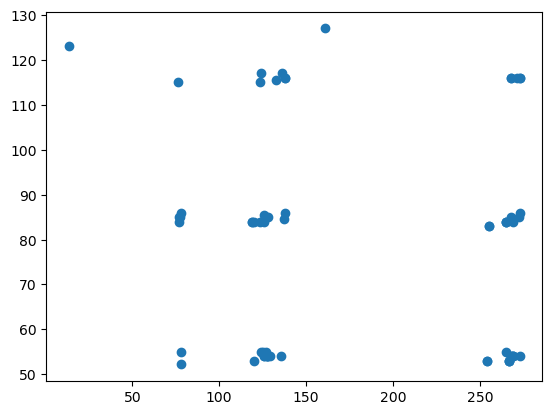

In [19]:
plt.scatter(all_kills_df.center_x, all_kills_df.center_y)

In [40]:
(top_left, top_right, bottom_right, bottom_left) = bbox_list

In [41]:
center_x = (top_left[0] + top_right[0]) / 2
center_y = (top_left[1] + bottom_left[1]) / 2
print(center_x, center_y)

122.0 55.0


In [44]:
all_kills_df.loc[all_kills_df['text'] == '']

,Unnamed: 0,bbox,text,conf,time_s


In [45]:
all_kills_df['bbox'] = all_kills_df['bbox'].apply(ast.literal_eval)

In [59]:
all_kills_df

,Unnamed: 0,bbox,text,conf,time_s,center_x,center_y
0,0,"[[93, 47], [151, 47], [151, 63], [93, 63]]",cLouding,0.997456,25.466667,122.0,55.0
1,1,"[[241, 47], [289, 47], [289, 61], [241, 61]]",Nitara,0.516252,25.466667,265.0,54.0
2,2,"[[93, 47], [151, 47], [151, 63], [93, 63]]",cLouding,0.996899,25.500000,122.0,55.0
3,3,"[[241, 47], [289, 47], [289, 61], [241, 61]]",Nitara,0.515822,25.500000,265.0,54.0
4,4,"[[93, 47], [151, 47], [151, 65], [93, 65]]",cLouding,0.996799,25.533333,122.0,56.0
...,...,...,...,...,...,...,...
1946,1946,"[[17, 137], [67, 137], [67, 155], [17, 155]]",100%0,0.815344,50.800000,42.0,146.0
1947,1947,"[[17, 137], [67, 137], [67, 153], [17, 153]]",100%0,0.865404,50.833333,42.0,145.0
1948,1948,"[[17, 137], [67, 137], [67, 153], [17, 153]]",100%0,0.580753,50.866667,42.0,145.0
1949,1949,"[[25, 135], [65, 135], [65, 153], [25, 153]]",00P0,0.197704,50.900000,45.0,144.0


In [47]:
all_kills_df[all_kills_df['text'].isna()]

,Unnamed: 0,bbox,text,conf,time_s
1814,1814,"[[105, 79], [137, 79], [137, 91], [105, 91]]",NaN,0.0,37.366667


In [48]:
all_kills_df.dropna(inplace=True)

In [49]:
all_kills_df

,Unnamed: 0,bbox,text,conf,time_s
0,0,"[[93, 47], [151, 47], [151, 63], [93, 63]]",cLouding,0.997456,25.466667
1,1,"[[241, 47], [289, 47], [289, 61], [241, 61]]",Nitara,0.516252,25.466667
2,2,"[[93, 47], [151, 47], [151, 63], [93, 63]]",cLouding,0.996899,25.500000
3,3,"[[241, 47], [289, 47], [289, 61], [241, 61]]",Nitara,0.515822,25.500000
4,4,"[[93, 47], [151, 47], [151, 65], [93, 65]]",cLouding,0.996799,25.533333
...,...,...,...,...,...
1946,1946,"[[17, 137], [67, 137], [67, 155], [17, 155]]",100%0,0.815344,50.800000
1947,1947,"[[17, 137], [67, 137], [67, 153], [17, 153]]",100%0,0.865404,50.833333
1948,1948,"[[17, 137], [67, 137], [67, 153], [17, 153]]",100%0,0.580753,50.866667
1949,1949,"[[25, 135], [65, 135], [65, 153], [25, 153]]",00P0,0.197704,50.900000


In [57]:
x_1 = int(820 / 1920 * 1280)
x_2 = int(1100 / 1920 * 1280)
w = x_2 - x_1
y_1 = 0
y_2 = int(50 / 1080 * 720)
h = y_2 - y_1
print(x_1, x_2, y_1, y_2, w, h)

546 733 0 33 187 33


In [58]:
x_1 = int(1450 / 1920 * 1280)
x_2 = int(1920 / 1920 * 1280)
w = x_2 - x_1
y_1 = 0
y_2 = int(310 / 1080 * 720)
h = y_2 - y_1
print(x_1, x_2, y_1, y_2, w, h)

966 1280 0 206 314 206


In [66]:
all_time_df = pd.read_csv('all_time.csv')
all_time_df['bbox'] = all_time_df['bbox'].apply(ast.literal_eval)

In [4]:
all_time_df

,Unnamed: 0,bbox,text,conf,time_s,current_frame
0,0,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.033333,1
1,1,"[[60, 8], [128, 8], [128, 34], [60, 34]]",00;12,0.360755,0.033333,1
2,2,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.066667,2
3,3,"[[60, 8], [128, 8], [128, 34], [60, 34]]",00;12,0.362643,0.066667,2
4,4,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.100000,3
...,...,...,...,...,...,...
5127,5127,"[[4, 6], [46, 6], [46, 36], [4, 36]]",10,0.999981,89.600000,2688
5128,5128,"[[60, 8], [128, 8], [128, 32], [60, 32]]",00 04,0.856225,89.600000,2688
5129,5129,"[[146, 6], [186, 6], [186, 38], [146, 38]]",12,0.999993,89.600000,2688
5130,5130,"[[6, 6], [46, 6], [46, 36], [6, 36]]",10,0.999590,89.633333,2689


In [5]:
centers_x = []
centers_y = []
for i, row in all_time_df.iterrows():
    (top_left, top_right, bottom_right, bottom_left) = row['bbox']
    centers_x.append((top_left[0] + top_right[0]) / 2)
    centers_y.append((top_left[1] + bottom_left[1]) / 2)
all_time_df['center_x'] = centers_x
all_time_df['center_y'] = centers_y

In [6]:
all_time_df = all_time_df.drop(['Unnamed: 0'], axis=1)

In [7]:
all_time_df

,bbox,text,conf,time_s,current_frame,center_x,center_y
0,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.033333,1,24.0,21.0
1,"[[60, 8], [128, 8], [128, 34], [60, 34]]",00;12,0.360755,0.033333,1,94.0,21.0
2,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.066667,2,24.0,21.0
3,"[[60, 8], [128, 8], [128, 34], [60, 34]]",00;12,0.362643,0.066667,2,94.0,21.0
4,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.100000,3,24.0,21.0
...,...,...,...,...,...,...,...
5127,"[[4, 6], [46, 6], [46, 36], [4, 36]]",10,0.999981,89.600000,2688,25.0,21.0
5128,"[[60, 8], [128, 8], [128, 32], [60, 32]]",00 04,0.856225,89.600000,2688,94.0,20.0
5129,"[[146, 6], [186, 6], [186, 38], [146, 38]]",12,0.999993,89.600000,2688,166.0,22.0
5130,"[[6, 6], [46, 6], [46, 36], [6, 36]]",10,0.999590,89.633333,2689,26.0,21.0


In [8]:
model = KMeans(n_clusters=3)
# model = DBSCAN()

In [9]:
time_center_x: pd.Series = all_time_df['center_x']
model.fit(time_center_x.values.reshape(-1, 1))

C:\Users\mrbab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [10]:
all_time_df['x_clusters'] = model.labels_

In [11]:
all_time_df[['current_frame', 'center_x']]

,current_frame,center_x
0,1,24.0
1,1,94.0
2,2,24.0
3,2,94.0
4,3,24.0
...,...,...
5127,2688,25.0
5128,2688,94.0
5129,2688,166.0
5130,2689,26.0


In [64]:
print(all_time_df[['current_frame', 'center_x']].groupby('current_frame').count().query('center_x > 3').count() == 0)

center_x    True
dtype: bool


Text(0.5, 1.0, 'Clusters according x-axis')

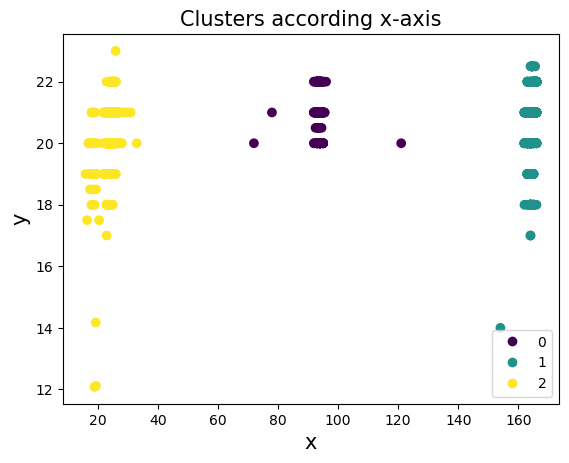

In [13]:
sc = plt.scatter(all_time_df['center_x'], all_time_df['center_y'], c=all_time_df['x_clusters'])
handles, labels = sc.legend_elements()
plt.legend(handles, labels, loc='lower right')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Clusters according x-axis', fontsize=15)

In [14]:
sorted_clusters_by_center_x: pd.DataFrame = all_time_df[['x_clusters', 'center_x']].groupby(
    'x_clusters').mean().sort_values(by='center_x', ascending=True)

In [15]:
sorted_clusters_by_center_x

,center_x
x_clusters,
2,24.096391
0,93.770997
1,164.192267


In [16]:
left_x_cluster = sorted_clusters_by_center_x.index.tolist()[0]
center_x_cluster = sorted_clusters_by_center_x.index.tolist()[1]
right_x_cluster = sorted_clusters_by_center_x.index.tolist()[2]

In [17]:
formatted_time = pd.DataFrame(columns=['left_score', 'center_score', 'right_score', 'time_s'])
# formatted_time['frame'] = np.sort(all_time_df['current_frame'].unique())

In [18]:
formatted_time

,left_score,center_score,right_score,time_s


In [19]:
all_time_df.columns

Index(['bbox', 'text', 'conf', 'time_s', 'current_frame', 'center_x',
       'center_y', 'x_clusters'],
      dtype='object')

In [20]:
# 0 - bbox , 1 - text, 2 - conf, 3 - time_s, 4 - center_x, 5 - center_y, 6 - x_clusters, 7 - y_clusters
detection_column = {
    left_x_cluster: 'left_score',
    center_x_cluster: 'center_score',
    right_x_cluster: 'right_score'
}
for frame, group in all_time_df.groupby('current_frame').apply(lambda x: x.values.tolist()).items():
    add_row = pd.DataFrame(columns=['frame', 'time_s', 'left_score', 'center_score', 'right_score'])
    add_row['frame'] = [int(frame)]
    for note in group:
        add_row['time_s'] = note[3]
        add_row[detection_column.get(note[7])] = [note[1]]
    formatted_time = pd.concat([formatted_time, add_row], ignore_index=True)

In [21]:
formatted_time['frame'] = formatted_time['frame'].apply(int)

In [22]:
formatted_time

,left_score,center_score,right_score,time_s,frame
0,0,00;12,NaN,0.033333,1
1,0,00;12,NaN,0.066667,2
2,0,00;12,NaN,0.100000,3
3,NaN,00;1n1,NaN,0.133333,4
4,NaN,00:10,NaN,0.166667,5
...,...,...,...,...,...
2396,10,0O UR,12,89.500000,2685
2397,10,"00,06",12,89.533333,2686
2398,10,"00,05",12,89.566667,2687
2399,10,00 04,12,89.600000,2688


In [23]:
formatted_time.to_csv('formatted_time.csv', index=False)

In [244]:
# formatted_time.to_csv('formatted_time.csv')

In [24]:
formatted_time

,left_score,center_score,right_score,time_s,frame
0,0,00;12,NaN,0.033333,1
1,0,00;12,NaN,0.066667,2
2,0,00;12,NaN,0.100000,3
3,NaN,00;1n1,NaN,0.133333,4
4,NaN,00:10,NaN,0.166667,5
...,...,...,...,...,...
2396,10,0O UR,12,89.500000,2685
2397,10,"00,06",12,89.533333,2686
2398,10,"00,05",12,89.566667,2687
2399,10,00 04,12,89.600000,2688


In [47]:
import regex as re
from datetime import timedelta

In [46]:
len('11')

2

In [33]:
timedelta(minutes=int('02'), seconds=int('02'))

datetime.timedelta(seconds=122)

In [51]:
current_time = timedelta(minutes=2, seconds=3)
pretty_timedelta = []
pretty_time_score = []
for i, row in formatted_time.iterrows():
    result = re.split('[:,.;]', str(row.center_score))
    times = list(filter(lambda t: t != '' and t.isnumeric() and len(t) == 2, result))  # split into 00:10 into 00 and 10
    if len(times) != 2:
        # pretty_time_score.append(None)
        current_time -= timedelta(seconds=1)
        hh, mm, ss = str(current_time).split(':')
        pretty_time_score.append(f'{mm}:{ss}')
        # pretty_timedelta.append(current_time)
        continue
    current_time = timedelta(minutes=int(times[0]), seconds=int(times[1]))
    hh, mm, ss = str(current_time).split(':')
    # pretty_timedelta.append(current_time)
    pretty_time_score.append(f'{mm}:{ss}')
    # pretty_time_score.append(f'{times[0]}:{times[1]}')

In [52]:
pretty_time_score

['00:12',
 '00:12',
 '00:12',
 '00:11',
 '00:10',
 '00:09',
 '00:08',
 '00:07',
 '00:06',
 '00:05',
 '00:04',
 '00:03',
 '00:02',
 '00:01',
 '00:00',
 '02:04',
 '02:03',
 '02:02',
 '02:01',
 '02:00',
 '01:59',
 '01:58',
 '01:57',
 '01:56',
 '01:55',
 '01:54',
 '01:53',
 '01:52',
 '01:51',
 '01:50',
 '01:49',
 '01:48',
 '01:47',
 '01:46',
 '01:45',
 '01:44',
 '01:43',
 '01:42',
 '01:41',
 '01:40',
 '01:39',
 '01:38',
 '01:37',
 '01:36',
 '01:35',
 '01:34',
 '01:33',
 '01:32',
 '01:31',
 '01:30',
 '01:29',
 '01:28',
 '01:27',
 '01:26',
 '01:25',
 '01:24',
 '01:23',
 '01:22',
 '01:21',
 '01:20',
 '01:19',
 '01:18',
 '01:17',
 '01:16',
 '01:15',
 '01:14',
 '01:13',
 '01:12',
 '01:11',
 '01:10',
 '01:09',
 '01:08',
 '01:07',
 '01:06',
 '01:05',
 '01:04',
 '01:03',
 '01:02',
 '01:01',
 '01:00',
 '00:59',
 '00:58',
 '00:57',
 '00:56',
 '00:55',
 '00:54',
 '00:53',
 '00:19',
 '00:19',
 '00:17',
 '00:16',
 '00:15',
 '00:14',
 '00:13',
 '00:12',
 '00:11',
 '00:10',
 '00:09',
 '00:08',
 '00:07',


In [53]:
formatted_time['pretty_time'] = pretty_time_score

In [54]:
formatted_time.to_csv('formatted_time.csv', index=False)

In [55]:
left_pretty_score = []
right_pretty_score = []
left_score = 0
right_score = 0
for i, row in formatted_time.iterrows():
    l_score = row.left_score
    r_score = row.right_score
    # region left_score preprocessing
    if l_score is not None and str(l_score).isnumeric():
        l_score = int(l_score)
        if l_score - left_score <= 15 or r_score == str(left_score):
            left_score = l_score
    left_pretty_score.append(left_score)
    # endregion
    # region right_score preprocessing
    if r_score is not None and str(r_score).isnumeric():
        r_score = int(r_score)
        if r_score - right_score <= 15 or r_score == l_score:
            right_score = r_score
    right_pretty_score.append(right_score)
    # endregion

In [56]:
formatted_time['left_pretty_score'] = left_pretty_score
formatted_time['right_pretty_score'] = right_pretty_score

In [30]:
formatted_time

,left_score,center_score,right_score,time_s,frame,pretty_time,left_pretty_score,right_pretty_score
0,0,00;12,NaN,0.033333,1,00:12,0,0
1,0,00;12,NaN,0.066667,2,00:12,0,0
2,0,00;12,NaN,0.100000,3,00:12,0,0
3,NaN,00;1n1,NaN,0.133333,4,None,0,0
4,NaN,00:10,NaN,0.166667,5,00:10,0,0
...,...,...,...,...,...,...,...,...
2396,10,0O UR,12,89.500000,2685,None,10,4
2397,10,"00,06",12,89.533333,2686,00:06,10,4
2398,10,"00,05",12,89.566667,2687,00:05,10,4
2399,10,00 04,12,89.600000,2688,None,10,4


In [57]:
formatted_time.to_csv('formatted_time.csv', index=False)

In [70]:
def time_processing(all_time_df: pd.DataFrame):
    all_time_df = all_time_df.drop(['Unnamed: 0'], axis=1)
    # region bbox to list
    all_time_df['bbox'] = all_time_df['bbox'].apply(ast.literal_eval)
    all_time_df
    # endregion
    # region calculate bbox's center_x and center_y
    centers_x = []
    centers_y = []
    for i, row in all_time_df.iterrows():
        (top_left, top_right, bottom_right, bottom_left) = row['bbox']
        centers_x.append((top_left[0] + top_right[0]) / 2)
        centers_y.append((top_left[1] + bottom_left[1]) / 2)
    all_time_df['center_x'] = centers_x
    all_time_df['center_y'] = centers_y
    # endregion
    # region find left/center/right zone by clustering center_x
    model = KMeans(n_clusters=3)
    time_center_x: pd.Series = all_time_df['center_x']
    model.fit(time_center_x.values.reshape(-1, 1))
    all_time_df['x_clusters'] = model.labels_

    sorted_clusters_by_center_x: pd.DataFrame = all_time_df[['x_clusters', 'center_x']].groupby(
        'x_clusters').mean().sort_values(by='center_x', ascending=True)
    left_x_cluster = sorted_clusters_by_center_x.index.tolist()[0]
    center_x_cluster = sorted_clusters_by_center_x.index.tolist()[1]
    right_x_cluster = sorted_clusters_by_center_x.index.tolist()[2]
    # endregion
    formatted_time = pd.DataFrame(columns=['left_score', 'center_score', 'right_score', 'time_s'])
    # region formate dataset with flattened l/c/r region
    # 0 - bbox , 1 - text, 2 - conf, 3 - time_s, 4 - center_x, 5 - center_y, 6 - x_clusters, 7 - y_clusters
    detection_column = {
        left_x_cluster: 'left_score',
        center_x_cluster: 'center_score',
        right_x_cluster: 'right_score'
    }
    for frame, group in all_time_df.groupby('current_frame').apply(lambda x: x.values.tolist()).items():
        add_row = pd.DataFrame(columns=['frame', 'time_s', 'left_score', 'center_score', 'right_score'])
        add_row['frame'] = [int(frame)]
        for note in group:
            add_row['time_s'] = note[3]
            add_row[detection_column.get(note[7])] = [note[1]]
        formatted_time = pd.concat([formatted_time, add_row], ignore_index=True)
    formatted_time['frame'] = formatted_time['frame'].apply(int)
    # endregion
    # region fill time (center) column
    # max time starts from 02:03
    # we subtract 1s from current_time if time is not detected
    # otherwise initialize current_time again
    current_time = timedelta(minutes=2, seconds=3)
    pretty_time_score = []
    for i, row in formatted_time.iterrows():
        result = re.split('[:,.;]', str(row.center_score))
        times = list(
            filter(lambda t: t != '' and t.isnumeric() and len(t) == 2, result))  # split into 00:10 into 00 and 10
        if len(times) != 2:
            current_time -= timedelta(seconds=1)
        else:
            current_time = timedelta(minutes=int(times[0]), seconds=int(times[1]))
        hh, mm, ss = str(current_time).split(':')
        pretty_time_score.append(f'{mm}:{ss}')
    # endregion
    formatted_time['pretty_time'] = pretty_time_score
    # region fill right and left command's score
    left_pretty_score = []
    right_pretty_score = []
    left_score = 0
    right_score = 0
    for i, row in formatted_time.iterrows():
        l_score = row.left_score
        r_score = row.right_score
        # region left_score preprocessing
        if l_score is not None and str(l_score).isnumeric():
            l_score = int(l_score)
            if l_score - left_score <= 15 or r_score == str(left_score):
                left_score = l_score
        left_pretty_score.append(left_score)
        # endregion
        # region right_score preprocessing
        if r_score is not None and str(r_score).isnumeric():
            r_score = int(r_score)
            if r_score - right_score <= 15 or r_score == l_score:
                right_score = r_score
        right_pretty_score.append(right_score)
        # endregion
    # endregion
    formatted_time['left_pretty_score'] = left_pretty_score
    formatted_time['right_pretty_score'] = right_pretty_score
    formatted_time.to_csv('formatted_time.csv', index=False)

In [68]:
all_time_df = pd.read_csv('all_time.csv')

In [71]:
time_processing(all_time_df)

C:\Users\mrbab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [212]:
for frame, row in all_time_df.groupby('current_frame').apply(lambda x: x.values.tolist()).items():
    break

1 [[[[12, 8], [36, 8], [36, 34], [12, 34]], '0', 0.9999829531442436, 0.0333333333333333, 1, 24.0, 21.0, 1, 0], [[[60, 8], [128, 8], [128, 34], [60, 34]], '00;12', 0.3607553832794313, 0.0333333333333333, 1, 94.0, 21.0, 0, 0]]


In [204]:
pd.DataFrame(all_time_df.groupby('current_frame').apply(lambda x: x.values.tolist()))

,0
current_frame,
1,"[[[[12, 8], [36, 8], [36, 34], [12, 34]], 0, 0..."
2,"[[[[12, 8], [36, 8], [36, 34], [12, 34]], 0, 0..."
3,"[[[[12, 8], [36, 8], [36, 34], [12, 34]], 0, 0..."
4,"[[[[60, 10], [124, 10], [124, 34], [60, 34]], ..."
5,"[[[[59, 7], [128, 7], [128, 35], [59, 35]], 00..."
...,...
2685,"[[[[6, 6], [46, 6], [46, 36], [6, 36]], 10, 0...."
2686,"[[[[4, 6], [46, 6], [46, 36], [4, 36]], 10, 0...."
2687,"[[[[4, 6], [46, 6], [46, 36], [4, 36]], 10, 0...."


In [35]:
center_x_cluster
y_model = DBSCAN()
y_model.fit(all_time_df['center_y'].values.reshape(-1, 1))

DBSCAN()

In [39]:
np.unique(y_model.labels_)

array([-1,  0,  1,  2], dtype=int64)

In [40]:
all_time_df['y_clusters'] = y_model.labels_

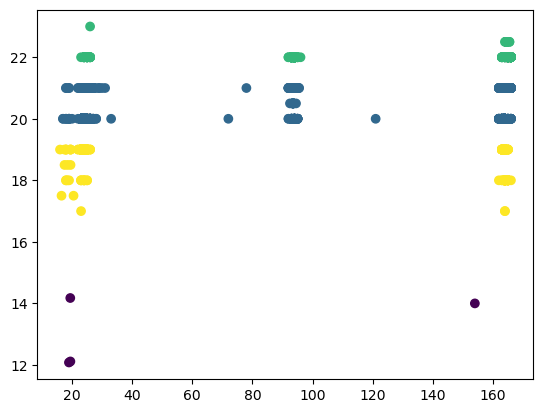

In [42]:
plt.scatter(all_time_df['center_x'], all_time_df['center_y'], c=all_time_df['y_clusters'])

In [24]:
all_time_df['center_x']

0        24.0
1        94.0
2        24.0
3        94.0
4        24.0
        ...  
5127     25.0
5128     94.0
5129    166.0
5130     26.0
5131    165.0
Name: center_x, Length: 5132, dtype: float64

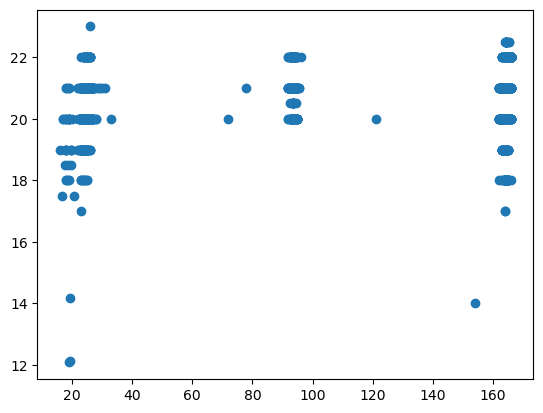

In [14]:
plt.scatter(all_time_df.center_x, all_time_df.center_y)